In [1]:
import os
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, minimize
import matplotlib.pyplot as plt

from scipy.io import loadmat
from datetime import datetime
from collections import defaultdict
import scipy.ndimage as ndi
import pickle
%matplotlib inline

In [2]:
from pysquid.rnet import ResistorNetworkModel
from pysquid.model import FluxModelTVPrior
from pysquid.linearModel import *
from pysquid.kernels.magpsf import GaussianKernel
from pysquid.util.helpers import *
import pysquid.viz.fake_data_plotting as fpd
from pysquid.opt.varbayes import Varbayes

from pysquid.gendata.fake_data import make_fake_data

In [3]:
import pysquid.deconvolve as deconvolve

## Parameters that the fake data was made with:

In [4]:
fakedata_file = '../pysquid/gendata/fake_data.npz'
if not os.path.exists(fakedata_file):
    make_fake_data()

In [5]:
fakefile = np.load(fakedata_file)
fakescan = fakefile['image_flux']
fake_g = fakefile['image_g']
fake_g_all = fakefile['all_g']
fake_offset = fakefile['offset']
fake_J_ext = fakefile['J_ext']
fake_psf = psf_params = fakefile['psf_params']

sigma = 0.02
noise = np.random.normal(0., sigma, size=fakescan.shape)
norm = np.max(np.abs(fakescan))
fakescan = fakescan/norm
Ly, Lx = fakescan.shape

fakedata = fakescan + noise
fake_g = fake_g/norm

#matshow(fakedata, aspect=0.5);
#matshow(fake_g, aspect=0.5);

In [6]:
mask = np.load('../pysquid/gendata/fake_data_hallprobe_interpolated.npy')
#plt.matshow(mask, cmap='Greys', aspect=0.2)

In [7]:
interpmask = 2.*mask-1
align = interpmask.copy()
yc, xc = fake_offset
align[yc:yc+Ly, xc:xc+Lx] *= fakescan

#fig, ax = plt.subplots(1,1, figsize=(10,10))
#lim = np.abs(fakescan).max()
#ax.matshow(align, cmap='Greys', aspect=0.2, vmin=-lim, vmax=lim)
#plt.savefig('../plots/fake_exterior.png',dpi=200)

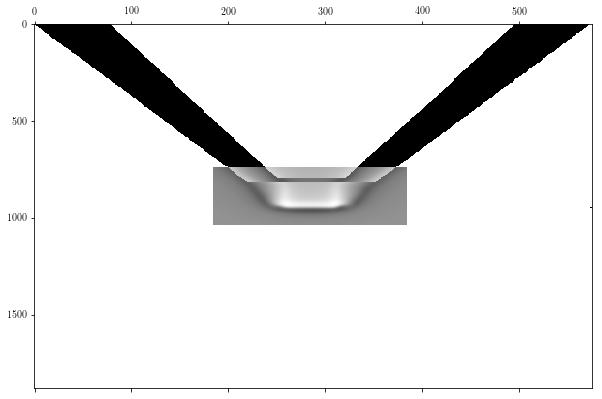

In [8]:
fakemask = mask.copy()
cut = 80
width = 20
startx, endx = 230, 350

fakemask[yc+cut:yc+Ly, xc:xc+Lx] = 0.
fakemask[yc+cut-width:yc+cut, startx:endx] = np.ones((width,endx-startx))

fig, ax = plt.subplots(1,1, figsize=(10,10))
interpmask = 2.*fakemask-1
align = interpmask.copy()
yc1, xc1 = np.array(fake_offset)-np.array([0,0])
align[yc1:yc1+Ly, xc1:xc1+Lx] *= fakescan

lim = np.abs(fakescan).max()
ax.matshow(align, cmap='Greys', aspect=0.2, vmin=-lim, vmax=lim)

## Fitting TV model

In [9]:
psf_params = fake_psf

In [10]:
def match_edge(data, model):
    """
    Matches affine transformation of model to data
    finds j such that
    min_{j,c} ||data - j model - c||^2
    for vectors data and model
    """
    N = len(data)
    sigma = model.sum()
    cos = data.dot(model)
    mag = model.dot(model)
    return (N * cos - sigma * data.sum()) / (N * mag - sigma ** 2)

In [11]:
kernel = GaussianKernel(fakedata.shape, params=psf_params, rxy=2.)
netkernel = GaussianKernel(fakemask.shape, params=psf_params, rxy=2.)

netmodel = ResistorNetworkModel(fakemask, kernel=netkernel, phi_offset=[yc1, xc1], 
                                gshape=(Ly, Lx), electrodes=[50,550])

In [12]:
J_ext = match_edge(fakedata[0], netmodel.ext_flux[0])
netmodel.updateParams('J_ext', [J_ext])
fitflux_sub = fakedata.ravel() - netmodel.ext_flux.ravel()

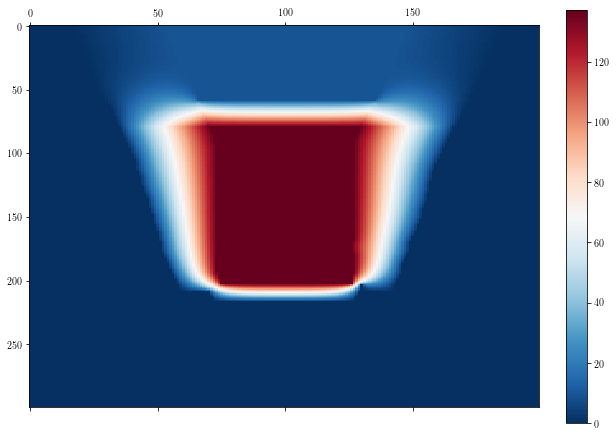

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe141dad048>)

In [13]:
py, px = kernel.py, kernel.px
Ly_pad, Lx_pad = kernel.Ly_pad, kernel.Lx_pad
oy, ox = fake_offset
true_g = fake_g_all[oy-py:oy-py+Ly_pad,
                    ox-px:ox-px+Lx_pad]*fake_J_ext[0]/norm
realg = true_g.ravel()- netmodel.g_ext.ravel()#+0.001*np.random.randn(model.N_pad)
matshow(realg.reshape(kernel.Ly_pad,-1), 0.5)

In [41]:
decon0 = deconvolve.TVDeconvolver(kernel, 1.4 * sigma, g_ext=netmodel.g_ext)

In [42]:
cost0 = []
def callback0(x, z, y, costlist = cost0, **kwargs):
    costlist += [decon0.cost(x, decon0.A.dot(x) - decon0.c, (fitflux_sub,))]
startg = np.random.randn(kernel.N_pad)/np.sqrt(kernel.N_pad)

gsol0 = decon0.deconvolve(fitflux_sub, startg, iprint=2, itnlim=80, rho=1.E-4,
                          eps_abs=1E-6, eps_rel=1E-6, algorithm='minimize',
                          callback=callback0)

Initial cost = 2.465e+03
Itn 0: cost = 2.421e+05, rho = 0.0002
	r = 2.826e+12, s = 2.532e-01 
Itn 1: cost = 4.463e+03, rho = 0.0004
	r = 1.935e+05, s = 1.013e+00 
Itn 2: cost = 2.528e+01, rho = 0.0008
	r = 1.778e+04, s = 1.282e-03 
Itn 3: cost = 1.756e+01, rho = 0.0016
	r = 2.976e+03, s = 1.481e-03 
Itn 4: cost = 1.540e+01, rho = 0.0032
	r = 4.685e+02, s = 1.598e-03 
Itn 5: cost = 1.484e+01, rho = 0.0064
	r = 1.000e+02, s = 1.890e-03 
Itn 6: cost = 1.469e+01, rho = 0.0128
	r = 2.801e+01, s = 2.327e-03 
Itn 7: cost = 1.466e+01, rho = 0.0256
	r = 7.626e+00, s = 2.933e-03 
Itn 8: cost = 1.465e+01, rho = 0.0512
	r = 2.380e+00, s = 3.026e-03 
Itn 9: cost = 1.466e+01, rho = 0.1024
	r = 6.916e-01, s = 3.251e-03 
Itn 10: cost = 1.467e+01, rho = 0.2048
	r = 1.908e-01, s = 3.458e-03 
Itn 11: cost = 1.468e+01, rho = 0.4096
	r = 4.852e-02, s = 3.675e-03 
Itn 12: cost = 1.468e+01, rho = 0.4096
	r = 1.147e-02, s = 3.829e-03 
Itn 13: cost = 1.468e+01, rho = 0.4096
	r = 3.759e-03, s = 3.666e-03 
Itn 1

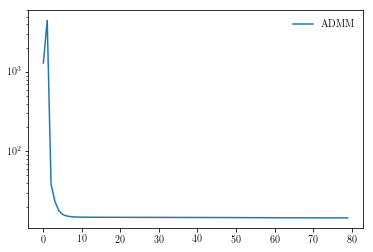

In [43]:
plt.plot(cost0, label="ADMM")
plt.legend(loc='best')
plt.yscale('log')

#plt.savefig("../plots/2016-12-15-testing-algorithms-fake-data.pdf")

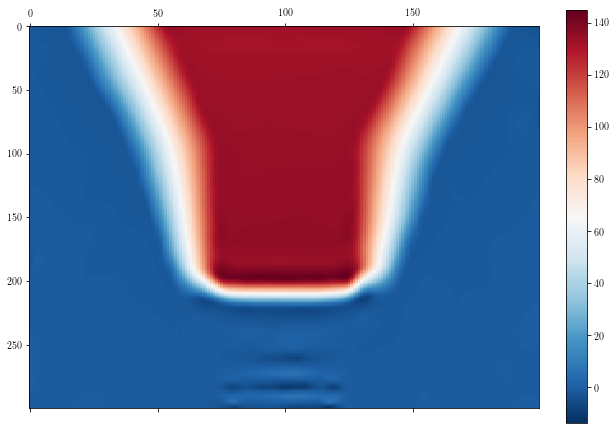

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe131510e10>)

In [44]:
matshow((gsol0).reshape(kernel.Ly_pad,-1) + netmodel.g_ext, 0.5)

In [39]:
run ../pysquid/viz/fake_data_plotting.py

<Figure size 432x288 with 0 Axes>

No handles with labels found to put in legend.


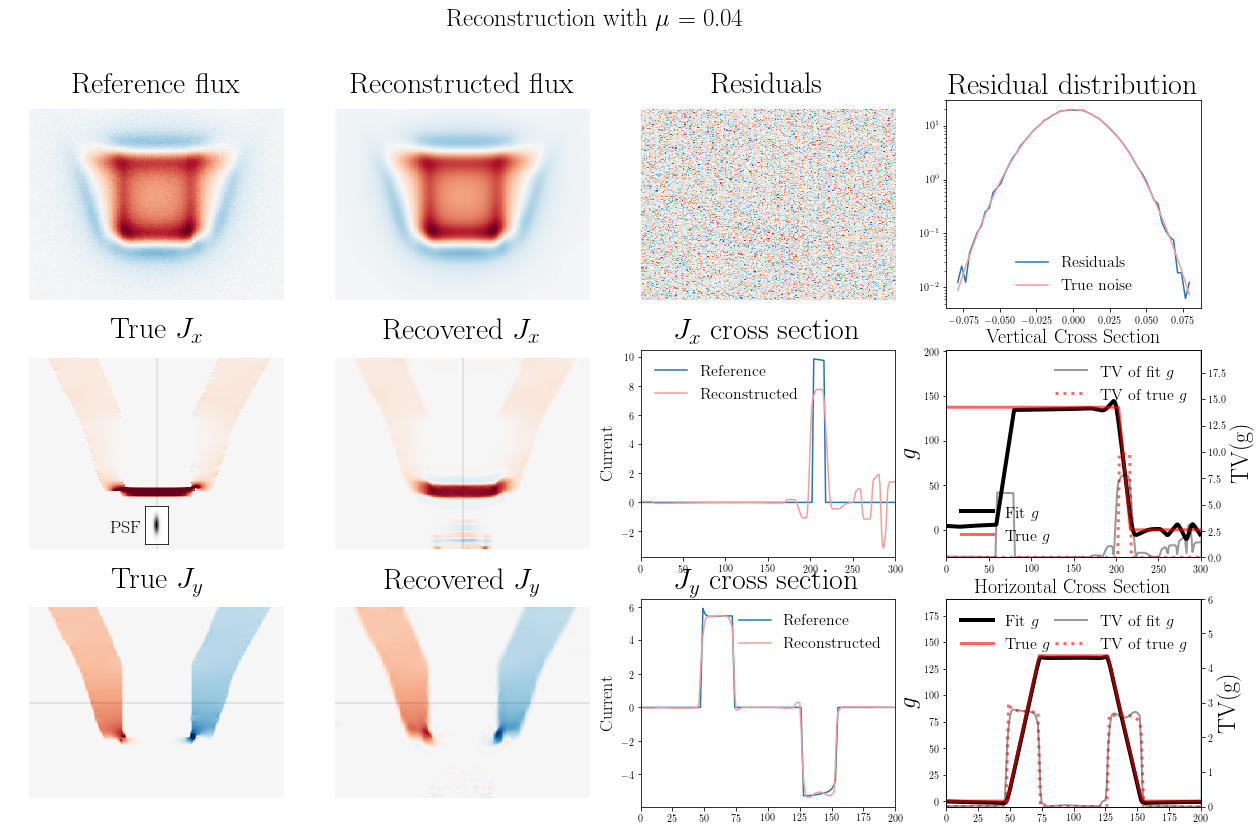

In [45]:
dfig, daxes = diagnostic(kernel, realg.reshape(kernel._padshape) + netmodel.g_ext, 
                         gsol0.reshape(kernel._padshape),
                         fitflux_sub.reshape(kernel._shape), 
                         netmodel, sigma, 2 * sigma)

In [77]:
#np.savez('data/2016-03-03-fake-data-fit.npz', 
#         g_sol=model.g_sol, ref_g = realg.reshape(model.Ly_pad,-1)+netmodel.ext_g,
#         fit_flux = model.modelflux.reshape(model._shape), ref_flux = model.fluxdata,
#         sigma = model.sigma, psf_params = model.kernel.psf_params, PSF=model.kernel.PSF)

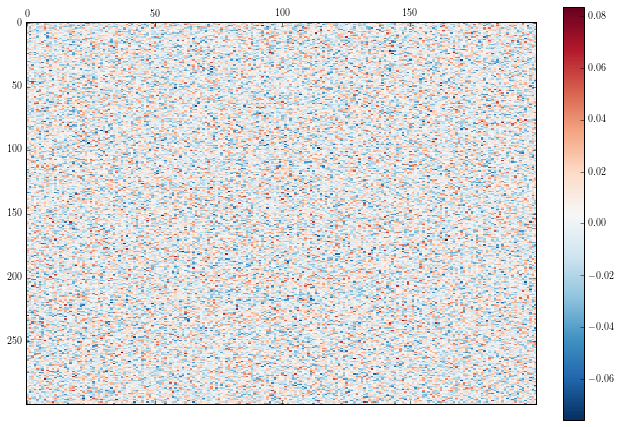

Pred mean: 0.000236388705665, Residual mean: 0.00542242604439 in sigmas


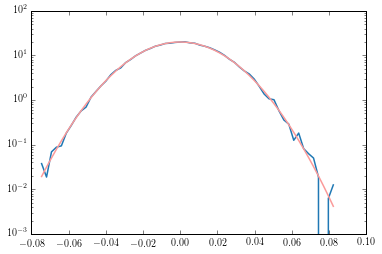

In [79]:

resim = model.residuals[:model.N].reshape(model.Ly, -1)
matshow(resim, aspect=0.5)#, vmin=-0.15, vmax=0.15)

hist, bins = np.histogram(resim, bins=60, density=True)
p = lambda x: np.exp(-(x/model.sigma)**2/2)/np.sqrt(2*np.pi*model.sigma**2)
resp = 0.5*(bins[1:]+bins[:-1])
plt.figure()
plt.plot(resp, hist)
plt.plot(resp, p(resp))
plt.yscale('log')
print("Pred mean: {}, Residual mean: {} in sigmas".format(resp.dot(p(resp)*np.diff(bins))/model.sigma, 
                                                          resp.dot(hist*np.diff(bins))/model.sigma))

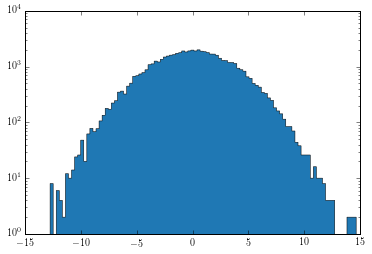

In [95]:
plt.hist(np.fft.fft2(resim).real.ravel(), bins=100, histtype='stepfilled');
plt.yscale('log')

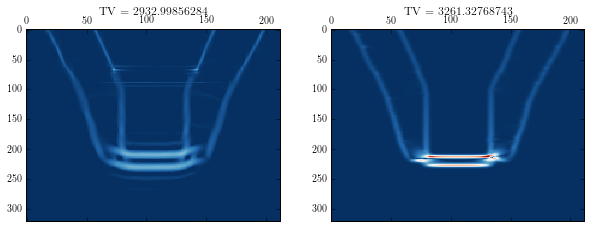

In [331]:
tv_modelg = admm.TV(model.gfield+model.extmodel.ext_g).reshape(model.Ly_pad,-1)
tv_realg = admm.TV(realg+model.extmodel.ext_g.ravel()).reshape(model.Ly_pad,-1)
fig, axes = plt.subplots(1,2, figsize=(10,5))
lim = max(tv_modelg.max(), tv_realg.max())
axes[0].matshow(tv_modelg, aspect=0.5, vmin=0, vmax=lim)
axes[0].set_title("TV = {}".format(tv_modelg.sum()))
axes[1].matshow(tv_realg, aspect=0.5, vmin=0, vmax = lim)
axes[1].set_title("TV = {}".format(tv_realg.sum()))

## Finite support

### Todo:


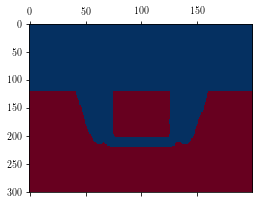

In [19]:
import scipy.ndimage as ndi
supportmask = mask[yc:yc+kernel.Ly_pad, xc:xc+kernel.Lx_pad]

zeromask = ndi.binary_erosion(1*(supportmask == 0), iterations=2,
                              border_value=1)
zeromask[:120] = 0.
plt.matshow(zeromask, aspect=0.5)

In [20]:
decon_fs = deconvolve.TVDeconvolver(kernel, 2 * sigma, support_mask=zeromask,
                                    g_ext=netmodel.g_ext)

In [21]:
costfs = []
def callback(x, z, y, costlist = costfs, **kwargs):
    costlist += [decon_fs.cost(x, z, (fitflux_sub,))]
    #costlist += [x, z, y]
    
#n = decon_fs._F.shape[1]
#x0 = np.random.randn(n)/np.sqrt(n) * decon_fs._F.sum(0)
    
gsol = decon_fs.deconvolve(fitflux_sub,
                           iprint=2, itnlim=20,
                           eps_abs=1E-6, eps_rel=1E-6, rho=1E-4,
                           algorithm='minimize', callback=callback)

Initial cost = 2.472e+03
Itn 0: cost = 1.850e+05, rho = 0.0002
	r = 1.224e+12, s = 2.417e-01 
Itn 1: cost = 9.451e+03, rho = 0.0004
	r = 5.192e+05, s = 9.626e-01 
Itn 2: cost = 3.595e+01, rho = 0.0008
	r = 3.879e+04, s = 5.551e-03 
Itn 3: cost = 2.239e+01, rho = 0.0016
	r = 6.591e+03, s = 4.334e-03 
Itn 4: cost = 1.795e+01, rho = 0.0032
	r = 7.689e+02, s = 4.051e-03 
Itn 5: cost = 1.688e+01, rho = 0.0064
	r = 1.868e+02, s = 4.980e-03 
Itn 6: cost = 1.650e+01, rho = 0.0128
	r = 4.727e+01, s = 6.885e-03 
Itn 7: cost = 1.648e+01, rho = 0.0256
	r = 1.432e+01, s = 7.970e-03 
Itn 8: cost = 1.644e+01, rho = 0.0512
	r = 3.939e+00, s = 9.214e-03 
Itn 9: cost = 1.643e+01, rho = 0.1024
	r = 1.415e+00, s = 1.106e-02 
Itn 10: cost = 1.643e+01, rho = 0.2048
	r = 4.638e-01, s = 1.278e-02 
Itn 11: cost = 1.646e+01, rho = 0.2048
	r = 1.106e-01, s = 1.453e-02 
Itn 12: cost = 1.646e+01, rho = 0.2048
	r = 3.728e-02, s = 1.427e-02 
Itn 13: cost = 1.644e+01, rho = 0.2048
	r = 1.962e-02, s = 1.394e-02 
Itn 1

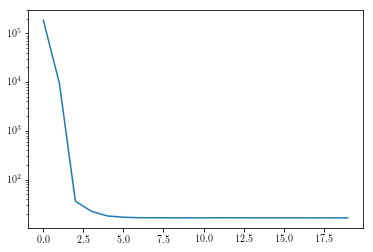

In [22]:
plt.plot(costfs) ;plt.yscale('log')

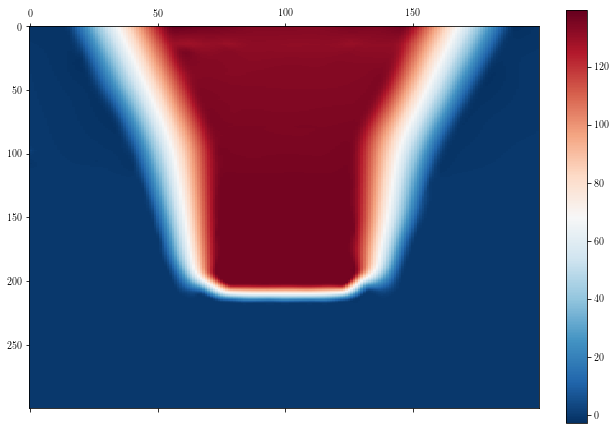

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7c55bbc748>)

In [27]:
matshow(gsol.reshape(kernel._padshape) + netmodel.g_ext, 0.5)

In [25]:
print('Finite support + TV nlnprob = {}'.format(decon0.nlnprob(fitflux_sub, gsol)))
print('TV nlnprob = {}'.format(decon0.nlnprob(fitflux_sub, gsol0)))
print('True g nlnprob = {}'.format(decon0.nlnprob(fitflux_sub, realg)))

Finite support + TV nlnprob = 18.77314677872688
TV nlnprob = 18.82945413635326
True g nlnprob = 21.342875058949303
